In [7]:
import pandas as pd

file_path = 'cowdata.csv'
cow_df = pd.read_csv(file_path, header=None)
column_names = ['name', 'race', 'age', 'milk', 'character', 'music']
cow_df.columns = column_names
cow_df


,name,race,age,milk,character,music
0,Clover,Holstein,2,20,lively,rock
1,Sunny,Ayrshire,2,10,kind,rock
2,Rose,Holstein,5,15,calm,country
3,Daisy,Ayrshire,4,25,calm,classical
4,Strawberry,Finncattle,7,35,calm,classical
5,Molly,Ayrshire,8,45,kind,country


In [8]:
def min_max_scale(column):
     min_val = column.min()
     max_val = column.max()
     if max_val - min_val == 0:
         return column - min_val

     return (column - min_val) / (max_val - min_val)

numerical_cols = ['age', 'milk']
text_cols = [ 'race', 'character', 'music'] #name?
cow_df[numerical_cols] = cow_df[numerical_cols].apply(min_max_scale)
cow_df


,name,race,age,milk,character,music
0,Clover,Holstein,0.000000,0.285714,lively,rock
1,Sunny,Ayrshire,0.000000,0.000000,kind,rock
2,Rose,Holstein,0.500000,0.142857,calm,country
3,Daisy,Ayrshire,0.333333,0.428571,calm,classical
4,Strawberry,Finncattle,0.833333,0.714286,calm,classical
5,Molly,Ayrshire,1.000000,1.000000,kind,country


In [9]:
import math
def l2(row_1, row_2):
    sum_of_squares = 0
    for col in numerical_cols:
        sum_of_squares += abs(row_1[col] - row_2[col]) ** 2
    dist = math.sqrt(sum_of_squares)
    return dist

def calculate_pairwise_distance(df, distance_function):
    num_rows = len(df)
    distances = [[0.0] * num_rows for _ in range(num_rows)]
    for i in range(num_rows):
        for j in range(num_rows): #Calculating 2 times, just to doublecheck
            row_1 = df.iloc[i]
            row_2 = df.iloc[j]

            dist = distance_function(row_1, row_2)
            distances[i][j] = dist

    return pd.DataFrame(distances)

pairwise_distances = calculate_pairwise_distance(cow_df, l2)
pairwise_distances

,0,1,2,3,4,5
0,0.000000,0.285714,0.520008,0.362656,0.937079,1.228904
1,0.285714,0.000000,0.520008,0.542941,1.097565,1.414214
2,0.520008,0.520008,0.000000,0.330772,0.661545,0.992317
3,0.362656,0.542941,0.330772,0.000000,0.575876,0.878052
4,0.937079,1.097565,0.661545,0.575876,0.000000,0.330772
5,1.228904,1.414214,0.992317,0.878052,0.330772,0.000000


In [10]:
import statistics

def create_distance_list(distances):
    distances_list = []
    for i in range(len(distances)):
        for j in range(i + 1, len(distances)):
            distances_list.append(distances.iloc[i, j])
    return distances_list


l2_distance_list = create_distance_list(pairwise_distances)


def get_std_dev(distance_list):
    std_dev = statistics.stdev(distance_list)
    print(f"Standard deviation of the distances: {std_dev}")
    return std_dev


l2_std = get_std_dev(l2_distance_list)

Standard deviation of the distances: 0.35692870655462167


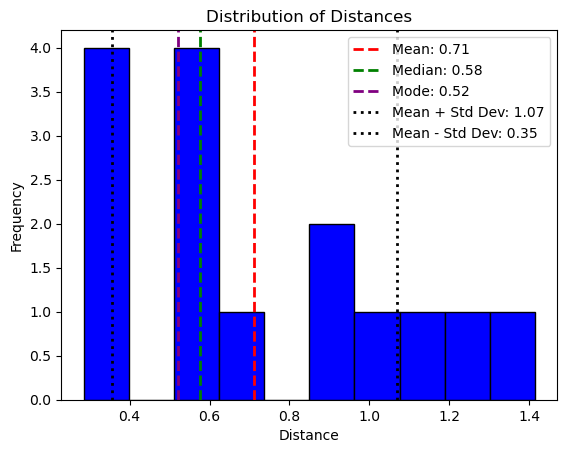

In [11]:
import statistics
import matplotlib.pyplot as plt

def create_distance_list_plot(distance_list):
    std_dev = statistics.stdev(distance_list)
    mean_dist = statistics.mean(distance_list)
    median_dist = statistics.median(distance_list)
    mode_dist = statistics.mode(distance_list)
    plt.hist(distance_list, color='blue', edgecolor='black')
    plt.axvline(mean_dist, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_dist:.2f}')
    plt.axvline(median_dist, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_dist:.2f}')
    plt.axvline(mode_dist, color='purple', linestyle='dashed', linewidth=2, label=f'Mode: {mode_dist:.2f}')
    plt.axvline(mean_dist + std_dev, color='black', linestyle='dotted', linewidth=2,
                label=f'Mean + Std Dev: {mean_dist + std_dev:.2f}')
    plt.axvline(mean_dist - std_dev, color='black', linestyle='dotted', linewidth=2,
                label=f'Mean - Std Dev: {mean_dist - std_dev:.2f}')
    plt.title('Distribution of Distances')
    plt.xlabel('Distance')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()


create_distance_list_plot(l2_distance_list)


In [12]:
from typing import List, Dict
from pandas import DataFrame


class Goodall:
    def __init__(self, df : DataFrame, cols: List[str]):
        self.col_chance: Dict[str, Dict[str, float]] = {}
        self.cols = cols

        for col in self.cols:
            count_map = df[col].value_counts().to_dict()
            values = len(df[col])
            for key in count_map:
                count_map[key] = count_map[key] / values

            self.col_chance[col] = count_map

    def get_similarity(self, row_1, row_2):
        sum_of_chances = 0
        for col in self.cols:
            if row_1[col] == row_2[col]:
                sum_of_chances += 1-self.col_chance[col][row_1[col]]**2
        return sum_of_chances/len(self.cols)

    def get_distance(self, row_1, row_2):
        return 1-self.get_similarity(row_1, row_2)

goodall_instance = Goodall(cow_df, text_cols)
goodall_distance = calculate_pairwise_distance(cow_df, goodall_instance.get_distance)
goodall_distance

,0,1,2,3,4,5
0,0.083333,0.703704,0.703704,1.000000,1.000000,1.000000
1,0.703704,0.157407,1.000000,0.750000,1.000000,0.453704
2,0.703704,1.000000,0.157407,0.750000,0.750000,0.703704
3,1.000000,0.750000,0.750000,0.203704,0.453704,0.750000
4,1.000000,1.000000,0.750000,0.453704,0.129630,1.000000
5,1.000000,0.453704,0.703704,0.750000,1.000000,0.157407


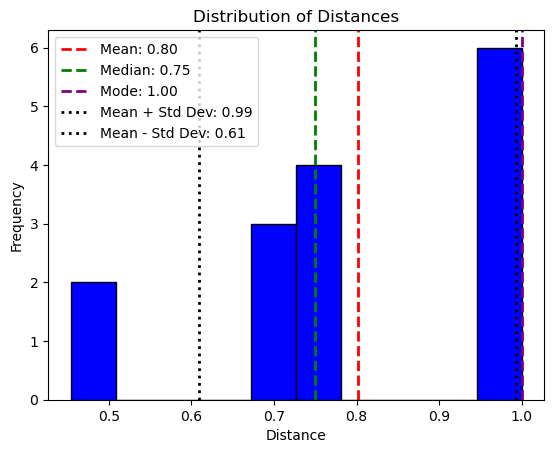

In [13]:
goodall_distance_list = create_distance_list(goodall_distance)
create_distance_list_plot(goodall_distance_list)

In [14]:
goodall_std = get_std_dev(goodall_distance_list)

Standard deviation of the distances: 0.19228667536662086


In [15]:
def mixed_metric(row1, row2):
    #Actualy lambda
    delta = len(numerical_cols) / (len(numerical_cols) + len(text_cols))
    return delta*l2(row1, row2)/l2_std+(1-delta)*goodall_instance.get_distance(row1, row2)/goodall_std

mixed_distance = calculate_pairwise_distance(cow_df, mixed_metric)
mixed_distance

,0,1,2,3,4,5
0,0.260028,2.515988,2.778554,3.526759,4.170500,4.497539
1,2.515988,0.491165,3.703099,2.948714,4.350351,3.000580
2,2.778554,3.703099,0.491165,2.710943,3.081631,3.307858
3,3.526759,2.948714,2.710943,0.635625,2.061078,3.324264
4,4.170500,4.350351,3.081631,2.061078,0.404489,3.491028
5,4.497539,3.000580,3.307858,3.324264,3.491028,0.491165


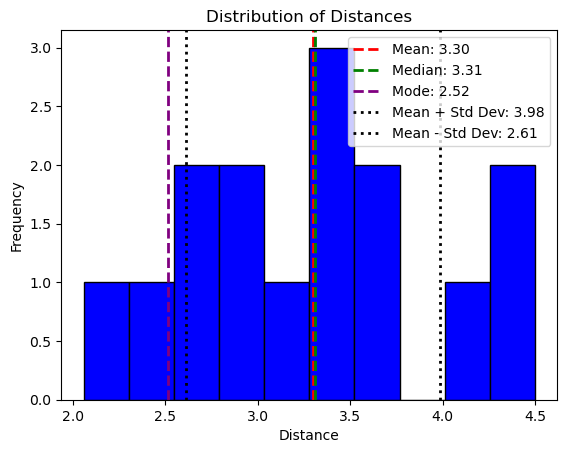

In [16]:
mixed_distance_list = create_distance_list(mixed_distance)
create_distance_list_plot(mixed_distance_list)

In [17]:
get_std_dev(mixed_distance_list)

Standard deviation of the distances: 0.6853221475898862


0.6853221475898862

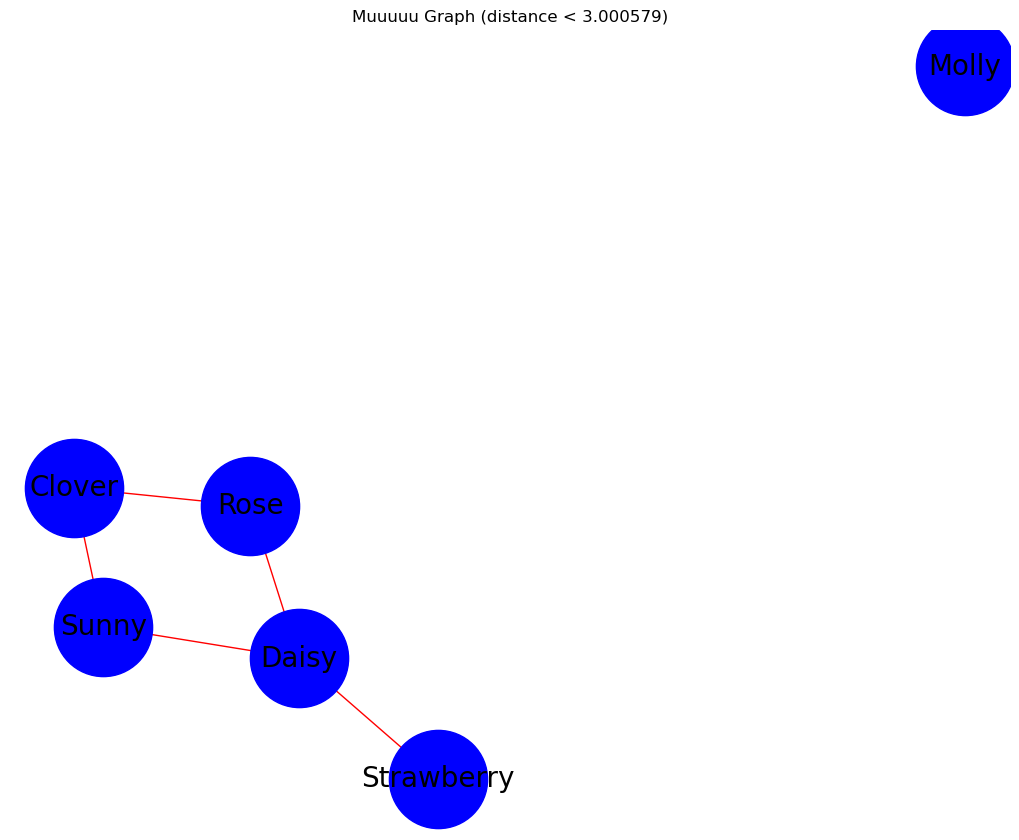

In [18]:
import networkx as nx
import matplotlib.pyplot as plt

threshold = 0
resolution = 1000.0

def create_graph(treshold):
    G = nx.Graph()
    num_cows = len(cow_df)
    G.add_nodes_from(range(num_cows))
    for i in range(num_cows):
        for j in range(i + 1, num_cows):
            distance = mixed_distance.iloc[i, j]
            if distance < treshold:
                G.add_edge(i, j)
    return G


for test_treshold in map(lambda x: x/resolution, range(int(0*resolution), int(10*resolution), 1)):
    G = create_graph(test_treshold)

    components = nx.number_connected_components(G)
    if components ==  2:
        threshold = test_treshold
    if components < 2:
        break

threshold = 3.000579
G = create_graph(threshold)
cow_names = cow_df['name'].to_dict()
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=1)
nx.draw(G, pos, labels=cow_names, with_labels=True, node_color='blue', node_size=5000, edge_color='red', font_size=20)
plt.title(f'Muuuuu Graph (distance < {threshold})')
plt.show()

